In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import pickle
import os
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

In [2]:
pip install numpy pandas seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd

DATA_PATH = r"C:\Users\preet\Downloads\Predicting_bike_share_demand\preprocessed_data.xlsx"
OUTPUT_DIR = "."

# Use pd.read_excel instead of pd.read_csv
df = pd.read_excel(DATA_PATH)

Modeling

In [6]:
# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def Calculate_vif(X):
    '''
    Calculating VIF
    '''
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [7]:
Calculate_vif(df[[i for i in df.describe().columns if i not in ['cnt']]])

,variables,VIF
0,season,3.533222
1,yr,1.020927
2,mnth,3.325725
3,holiday,2.284460
4,weekday,1.021473
5,workingday,33.650138
6,weathersit,1.738609
7,temp,1.215146
8,hum,1.905125
9,windspeed,1.165212


workingday 33.7 Too high → must drop

is_weekend 14.57 High — correlated with workingday

since workingday is the native feature , drop is_weekend ( feature added during feature engineering)

In [8]:
# This will not raise an error if 'is_weekend' is missing
df = df.drop(columns=['is_weekend'], errors='ignore')

In [9]:
Calculate_vif(df[[i for i in df.describe().columns if i not in ['cnt']]])

,variables,VIF
0,season,21.113657
1,yr,1.944519
2,mnth,15.234046
3,holiday,1.099315
4,weekday,3.096635
5,workingday,3.261981
6,weathersit,13.038336
7,temp,9.501432
8,hum,25.603454
9,windspeed,5.292992


In [10]:
# Checking categoiries in season column.
df['season'].value_counts()

season
3    188
2    184
1    180
4    178
Name: count, dtype: int64

In [11]:
season_dummies = pd.get_dummies(df['season'], prefix='season', drop_first=True)
df = pd.concat([df, season_dummies], axis=1)
df = df.drop(columns=['season','hum'])

In [12]:
Calculate_vif(df[[i for i in df.describe().columns if i not in ['cnt']]])

,variables,VIF
0,yr,1.944191
1,mnth,4.582960
2,holiday,1.092670
3,weekday,3.082351
4,workingday,3.217273
5,weathersit,6.125517
6,temp,6.699629
7,windspeed,5.247690


The time features (yr, mnth) -fine

The categorical features (holiday, weekday, workingday) -fine

The weather block (weathersit, temp, windspeed) still carries mild-to-heavy correlation — but acceptable, this is expected and normal for the Bike Sharing dataset.

In [13]:
#standardise continuous features

from sklearn.preprocessing import StandardScaler

num_cols = ['temp', 'windspeed', 'yr']  # numeric columns in final features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

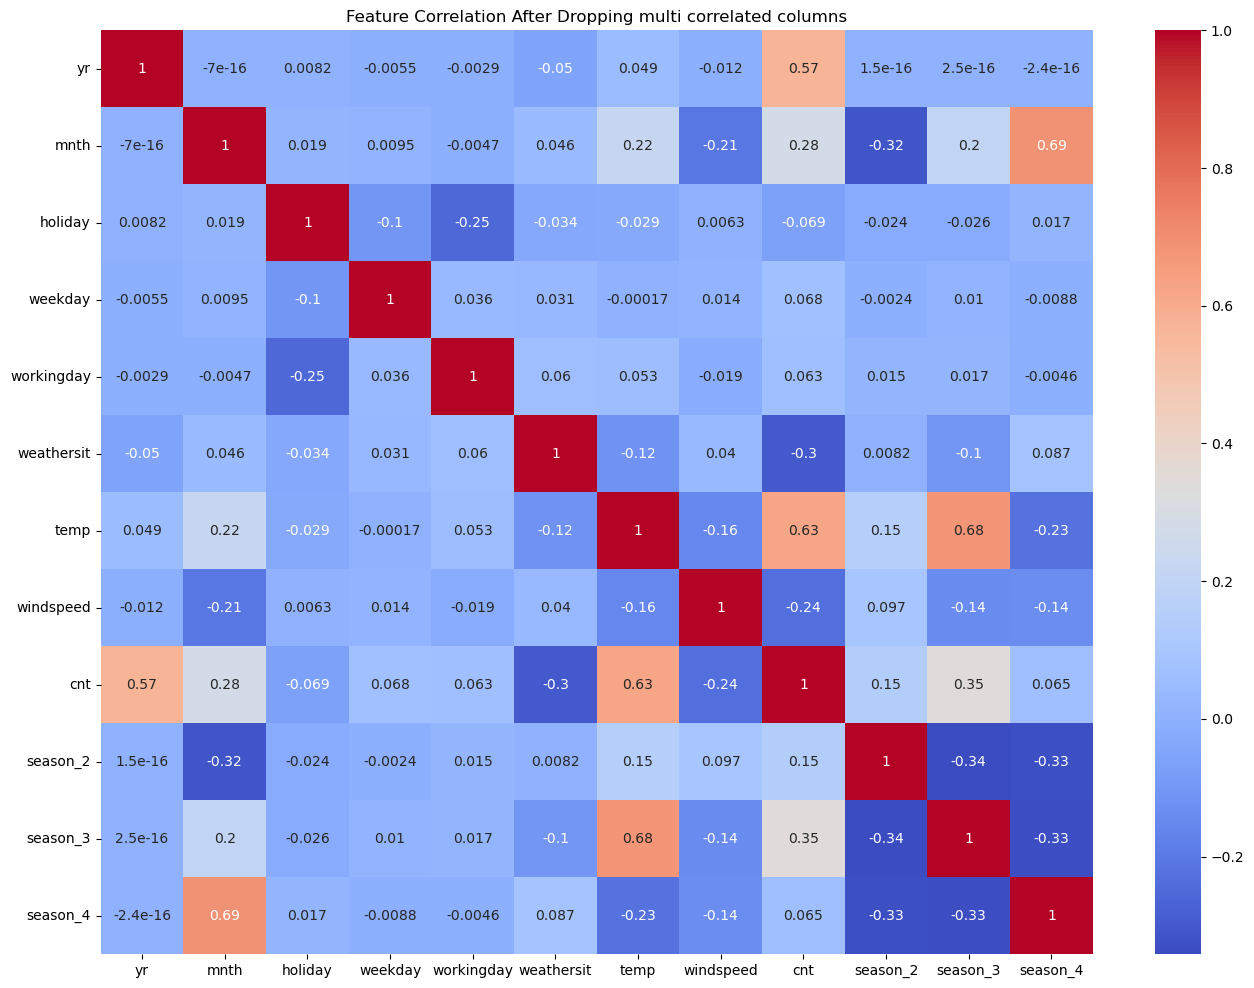

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))
# Add numeric_only=True to the .corr() method
sns.heatmap(df.corr (numeric_only = True), annot = True, cmap ='coolwarm')
plt.title("Feature Correlation After Dropping multi correlated columns")
plt.show()

In [15]:
# Checking categoiries in holiday columns.
df['holiday'].value_counts()

holiday
0    709
1     21
Name: count, dtype: int64

In [16]:
# Checking categoiries in Functioning Day columns.
df['workingday'].value_counts()

workingday
1    499
0    231
Name: count, dtype: int64

In [17]:

df.head()

,yr,mnth,holiday,weekday,workingday,weathersit,temp,windspeed,cnt,season_2,season_3,season_4
0,-1.0,1,0,6,0,2,-0.827613,-0.387833,985,False,False,False
1,-1.0,1,0,0,0,2,-0.722069,0.748899,801,False,False,False
2,-1.0,1,0,1,1,1,-1.635432,0.745931,1349,False,False,False
3,-1.0,1,0,2,1,1,-1.615560,-0.389769,1562,False,False,False
4,-1.0,1,0,3,1,1,-1.468226,-0.046477,1600,False,False,False


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    float64
 1   mnth        730 non-null    int64  
 2   holiday     730 non-null    int64  
 3   weekday     730 non-null    int64  
 4   workingday  730 non-null    int64  
 5   weathersit  730 non-null    int64  
 6   temp        730 non-null    float64
 7   windspeed   730 non-null    float64
 8   cnt         730 non-null    int64  
 9   season_2    730 non-null    bool   
 10  season_3    730 non-null    bool   
 11  season_4    730 non-null    bool   
dtypes: bool(3), float64(3), int64(6)
memory usage: 53.6 KB


LINEAR REGRESSION

1. Importing necessary libraries

In [19]:
# lets import train test split for splitting the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

2. Splitting Train & Test dataset

In [20]:
# Creating a dependent variable for rented bike count
dependent_variable = 'cnt'

In [21]:
# Create a list of independent variables
independent_variables = list(set(df.columns.tolist()) - {dependent_variable})
independent_variables

['holiday',
 'season_4',
 'weathersit',
 'temp',
 'yr',
 'mnth',
 'workingday',
 'weekday',
 'season_3',
 'windspeed',
 'season_2']

In [22]:
# Create the dependent variable data
y = np.sqrt(df['cnt'])

# Create the data of independent variables
X = df.drop('cnt',axis=1)

In [23]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [24]:
X_train[0:10]

,yr,mnth,holiday,weekday,workingday,weathersit,temp,windspeed,season_2,season_3,season_4
239,-1.0,8,0,0,0,1,1.155777,1.473059,False,True,False
97,-1.0,4,0,5,1,2,-0.873163,0.470861,True,False,False
503,1.0,5,0,6,0,1,0.570645,-1.374597,True,False,False
642,1.0,10,0,5,1,1,0.652627,-1.085875,False,False,True
498,1.0,5,0,1,1,2,0.424896,0.286337,True,False,False
303,-1.0,10,0,1,1,1,-0.850388,-1.085875,False,False,True
570,1.0,7,0,3,1,1,1.249281,-0.331650,False,True,False
250,-1.0,9,0,4,1,3,0.755997,0.028985,False,True,False
17,-1.0,1,0,2,1,2,-1.524466,-0.564240,False,False,False
595,1.0,8,0,0,0,2,0.766490,-1.342660,False,True,False


In [26]:
# Add errors='ignore' to safely drop the column if it exists
X_train = X_train.drop(columns=['dteday'], errors='ignore')
X_test = X_test.drop(columns=['dteday'], errors='ignore')

In [27]:
# Save the names *before* scaling
feature_names = X_train.columns

In [28]:
# Now your scaler code will work
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
# Checking shape
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(584, 11)
(584,)
(146, 11)
(146,)


In [30]:
X_train[0:10]

array([[0.        , 0.63636364, 0.        , 0.        , 0.        ,
        0.        , 0.80735084, 0.65710461, 0.        , 1.        ,
        0.        ],
       [0.        , 0.27272727, 0.        , 0.83333333, 1.        ,
        0.5       , 0.34478502, 0.46257665, 1.        , 0.        ,
        0.        ],
       [1.        , 0.36363636, 0.        , 1.        , 0.        ,
        0.        , 0.67395007, 0.1043704 , 1.        , 0.        ,
        0.        ],
       [1.        , 0.81818182, 0.        , 0.83333333, 1.        ,
        0.        , 0.69264081, 0.16041174, 0.        , 0.        ,
        1.        ],
       [1.        , 0.36363636, 0.        , 0.16666667, 1.        ,
        0.5       , 0.64072168, 0.42676029, 1.        , 0.        ,
        0.        ],
       [0.        , 0.81818182, 0.        , 0.16666667, 1.        ,
        0.        , 0.34997731, 0.16041174, 0.        , 0.        ,
        1.        ],
       [1.        , 0.54545455, 0.        , 0.5       , 1.

3. Model building with training & testing

In [31]:
# Fitting Multiple Linear Regression to the Training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [32]:
# Cheeck coefficents
regressor.coef_

array([ 15.29878649,  -1.49285271,  -4.39245588,   2.82208294,
         0.67777857, -13.27914838,  32.85706534,  -8.35833196,
         9.5281136 ,   6.89638575,  12.76288656])

In [33]:
# Use `feature_names` as the index
pd.DataFrame(regressor.coef_, index=feature_names, columns=['Coefficient'])

,Coefficient
yr,15.298786
mnth,-1.492853
holiday,-4.392456
weekday,2.822083
workingday,0.677779
weathersit,-13.279148
temp,32.857065
windspeed,-8.358332
season_2,9.528114
season_3,6.896386


In [34]:
# Check intercept
regressor.intercept_

np.float64(37.18076609269221)

In [35]:
# Checking score
regressor.score(X_train,y_train)

0.7954404791344494

In [36]:
# Y peredictions on train data
y_pred_train = regressor.predict(X_train)

# y predictions on test data
y_pred = regressor.predict(X_test)

4. Model evaluation

In [37]:
# Evaluation of test data set

#Calculate Mean Absolute Error.
MAE = mean_absolute_error(y_test,y_pred)
print(f"The Mean Absolute Error (MAE) is {MAE}.")

#Calculate  Mean Squared Error
MSE = mean_squared_error(y_test,y_pred)
print(f"The Mean Squred Error(MSE) is {MSE}.")

#Calculate Root Mean Squared Error
RMSE = np.sqrt(MSE)
print(f"The Root Mean Squared Error(RMSE) is {RMSE}.")

#Calculate R2 Score
R2 = r2_score(y_test,y_pred)
print(f"The R2 Score is {R2}.")

#Calculate adjusted R2 Score
adj_r2 = 1-(1-r2_score(y_test,y_pred))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print(f"Adjusted R2 is {adj_r2}.")

The Mean Absolute Error (MAE) is 4.91459474440674.
The Mean Squred Error(MSE) is 41.16752787636727.
The Root Mean Squared Error(RMSE) is 6.416192630865073.
The R2 Score is 0.8616817741003586.
Adjusted R2 is 0.850327292869791.


In [38]:
#Saving train data set results in dataframe.
test_dict = {'Model':"Linear Regression",
              'MAE':round(MAE,4),
              'MSE':round(MSE,4),
              'RMSE':round(RMSE,4),
              'R2_score':round(R2,4),
              'Adjusted_R2':round(adj_r2,4)}

In [39]:
# create test_result dataframe
test_results_df = pd.DataFrame(test_dict,index=[0])
test_results_df

,Model,MAE,MSE,RMSE,R2_score,Adjusted_R2
0,Linear Regression,4.9146,41.1675,6.4162,0.8617,0.8503


With an R² of 0.8575 and balanced train–test performance, the model shows strong predictive ability and minimal overfitting. Slight prediction errors indicate scope for further improvement through non-linear modeling

In [40]:
# define a fucntion to plot predicted y values and actual y values
def plot_Pred_vs_actual(y_pred_test,y_test):
  ''' 
  Visualize predicted values with actual values.
  '''
  plt.figure(figsize=(20,8))
  plt.plot(y_pred_test)
  plt.plot(np.array(y_test))
  plt.legend(["Predicted","Actual"],)
  plt.title("Predicted V/S Actual")
  plt.show()

In [41]:
# define a function to plot scatter plot for y_test and y_actual.
def plot_scatter(y_pred_test,y_test):
  '''
  Plot scatter plot for y_test values and y_test values. To check how close we are to regresson line
  '''
  plt.figure(figsize=(16,5))
  sns.regplot(x = y_test,y = y_pred_test, line_kws={'color':'red'})
  plt.xlabel('Actual')
  plt.ylabel("Predicted")
  plt.title("Actual v/s Predicted")

In [42]:
# Residuals of the regression are normally distributed.(Homoscedasticity refers to whether these residuals are equally distributed).
def Residual_distPlot(y_pred_test,y_test):  
  '''
  Checks the distribution of residals
  '''        
                                                    
  plt.figure(figsize=(10,5))
  sns.distplot(x = y_test-y_pred_test)
  plt.title("Residual Distribution")

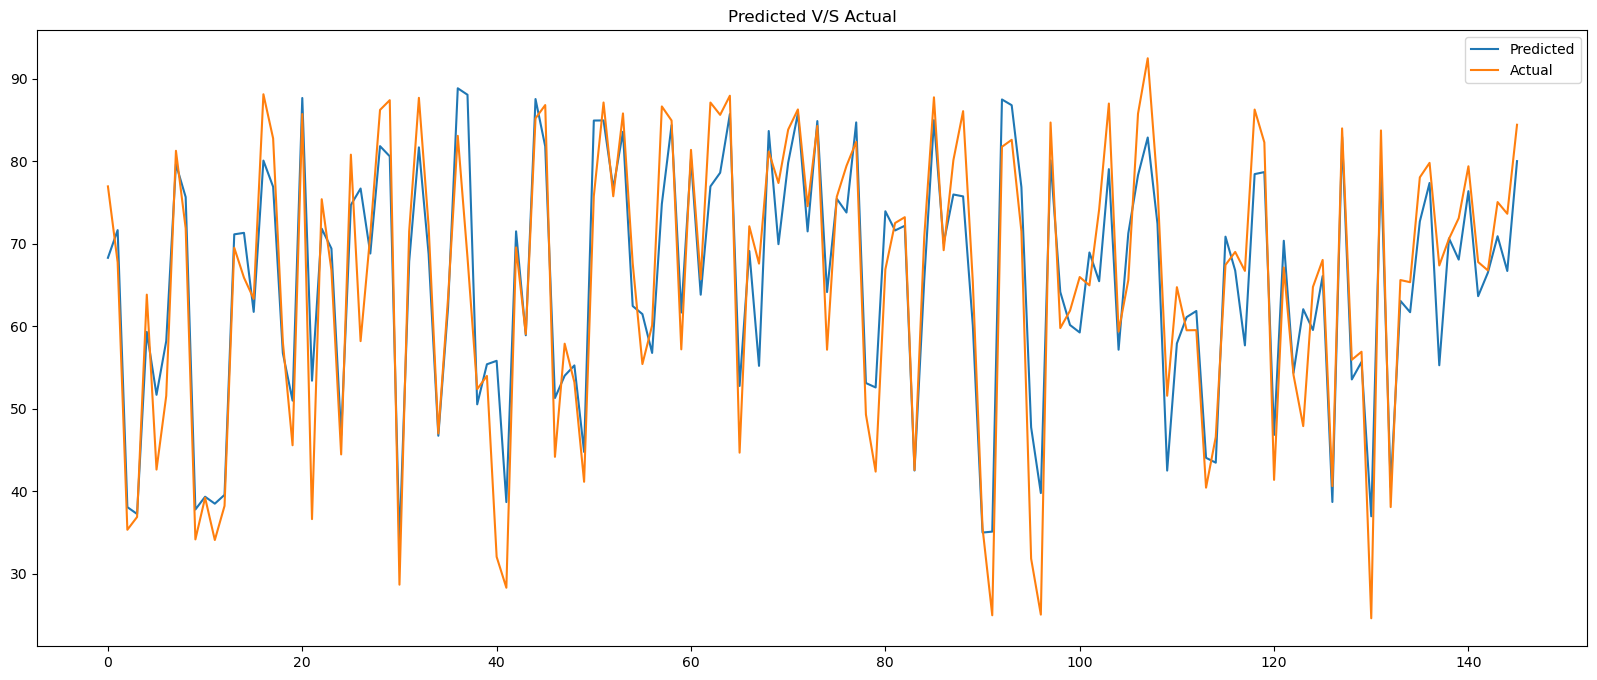

In [43]:
plot_Pred_vs_actual(y_pred,y_test)

Text(0.5, 0, 'y_predicted')

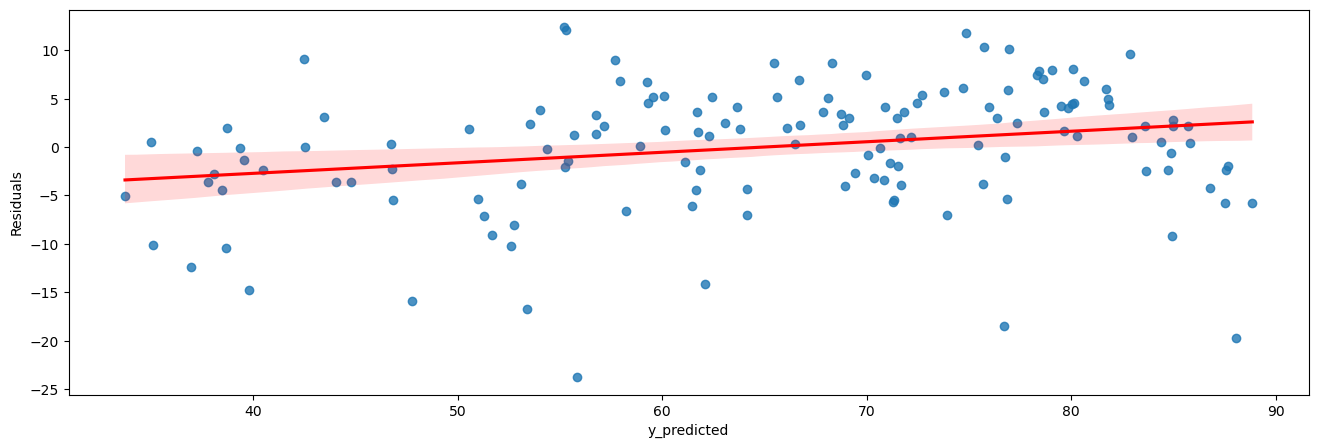

In [44]:
# Check Homoscedasticity by plotting y_predicted values and the residuals
plt.figure(figsize=(16,5))
sns.regplot(x = y_pred, y = y_test-y_pred,line_kws={'color':'red'})
plt.ylabel('Residuals')
plt.xlabel('y_predicted')

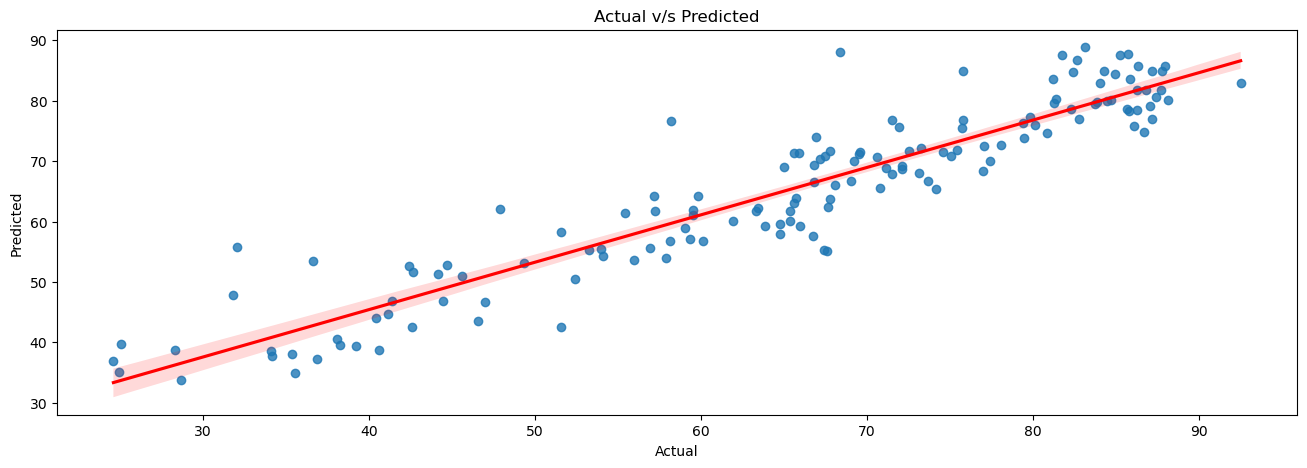

In [45]:
# Checking how predicted values and actual values are close  to the regression line
plot_scatter(y_pred,y_test)

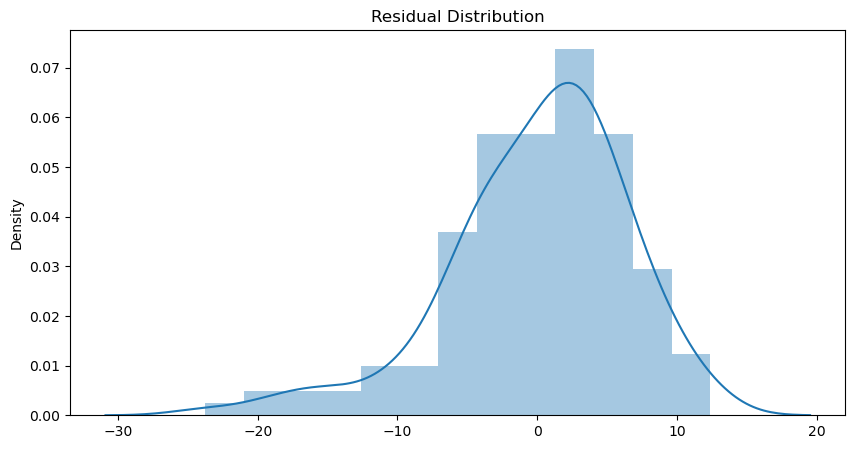

In [46]:
Residual_distPlot(y_pred,y_test)

The residuals form a near-normal distribution centered around zero, which indicates that the Linear Regression model is performing well — the errors are random, balanced, and not biased in any particular direction.

GENERAL INSIGHTS - plots after model evaluation
What are residuals?

Residuals = (Actual value − Predicted value)

They represent how far off your model’s predictions are for each data point.

If residual = 0 → perfect prediction

Negative residual → model overpredicted

Positive residual → model underpredicted